In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import os

In [104]:
def human_readable_size(n):
    """Convert integer size into human-readable string (K, M, G)."""
    if n >= 1_000_000_000:
        return f"{n // 1_000_000_000}G"
    elif n >= 1_000_000:
        return f"{n // 1_000_000}M"
    elif n >= 1_000:
        return f"{n // 1_000}K"
    else:
        return str(n)

In [121]:
def plot_scaling(csv_path, filter_map, show_speedup=True, save=False, filename=None):
    """
    Plot execution time or speedup vs number of threads (CPU) or threads per block (GPU),
    filtered by executable(s) and input file(s).
    
    Args:
        csv_path (str): Path to the CSV file.
        filter_map (dict): Dictionary {column -> list_of_values} for filtering the dataset.
            Example (CPU): {
                'Num Threads': [1, 2, 4, 8],
                'Input File': ['file1.txt'],
                'Executable': ['prog1.exe']
            }
            Example (GPU): {
                'Threads per Block': [32, 64, 128],
                'Input File': ['file1.txt'],
                'Executable': ['prog1.exe']
            }
        show_speedup (bool): If True, plot speedup instead of execution time.
        save (bool): If True, save the plot under ../plots/.
        filename (str): Optional custom filename for the saved plot.
    """
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Strip whitespace from strings
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    # Required columns
    required_cols = {"Executable", "Input File", "Avg Execution Time (ms)"}
    missing_required = required_cols - set(df.columns)
    if missing_required:
        raise ValueError(f"CSV is missing required columns: {missing_required}")
    
    df['Input Size'] = df['Input File'].str.extract(r'numbers_(\d+)\.txt').astype(int)

    # Decide CPU/GPU mode based on filter_map
    cpu_key = "Num Threads"
    gpu_key = "Threads per Block"
    has_cpu = cpu_key in filter_map
    has_gpu = gpu_key in filter_map
    
    if has_cpu and has_gpu:
        raise ValueError("Filter map cannot contain both 'Num Threads' and 'Threads per Block'.")
    elif has_cpu:
        if cpu_key not in df.columns:
            raise ValueError(f"Column '{cpu_key}' not found in CSV.")
        x_col = cpu_key
        xlabel = "Number of Threads"
        mode = "cpu"
    elif has_gpu:
        if gpu_key not in df.columns:
            raise ValueError(f"Column '{gpu_key}' not found in CSV.")
        x_col = gpu_key
        xlabel = "Threads per Block"
        mode = "gpu"
    else:
        raise ValueError("Filter map must contain either 'Num Threads' or 'Threads per Block'.")
    
    # Validate all filter_map keys exist in CSV
    invalid_keys = [col for col in filter_map if col not in df.columns]
    if invalid_keys:
        raise ValueError(f"Filter map contains invalid column(s): {invalid_keys}")
    
    # Ensure numeric type for x_col
    df[x_col] = df[x_col].astype(int)
    # Apply filters
    for col, values in filter_map.items():
        df = df[df[col].isin(values)]
    
    if df.empty:
        raise ValueError("No rows match the provided filters.")
    
    plt.figure(figsize=(10, 6))
    
    # Iterate over each executable and input file
    for exe in df['Executable'].unique():
        for size in df['Input Size'].unique():
            subset = df[(df['Executable'] == exe) & (df['Input Size'] == size)]
            subset = subset.sort_values(x_col)
            
            if subset.empty:
                continue
            
            x = subset[x_col]
            y = subset['Avg Execution Time (ms)']
            
            if show_speedup:
                baseline = y.iloc[0]
                y = baseline / y
            
            label = f"{exe} - {human_readable_size(size)}"
            plt.plot(x, y, marker='o', label=label)
    
    # Force all available values as x-axis ticks
    all_x = sorted(df[x_col].unique())
    plt.xticks(all_x)
    
    plt.xlabel(xlabel)
    plt.ylabel("Speedup" if show_speedup else "Avg Execution Time (ms)")
    plt.title(f"Performance Plot ({'Speedup' if show_speedup else 'Avg Execution Time'}) [{mode.upper()}]")
    # position legend on the right outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    if save:
        # Create ../plots folder if it does not exist
        output_dir = os.path.join(os.path.dirname(csv_path), "..", "plots")
        os.makedirs(output_dir, exist_ok=True)
        
        # Choose filename based on mode
        speed_mode = "speedup" if show_speedup else "execution_time"
        filename = f"{mode}_{speed_mode}_plot.png" if filename is None else filename
        filepath = os.path.join(output_dir, filename)
        
        plt.savefig(filepath, bbox_inches="tight")
        print(f"Plot saved to {filepath}")
    else:
        plt.show()

Plot saved to ../tables\..\plots\exec_time_DTF_vanilla_small.png


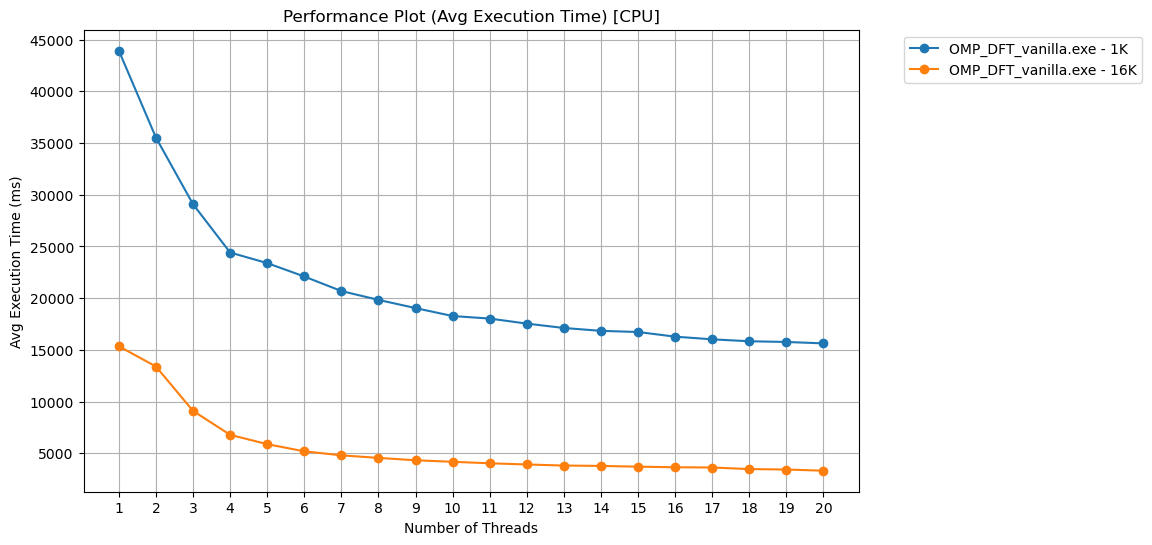

In [122]:
plot_scaling(
    "../tables/CPU_means.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['numbers_1024.txt','numbers_16384.txt'],
        'Executable': ['OMP_DFT_vanilla.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_DTF_vanilla_small.png"
)

Plot saved to ../tables\..\plots\exec_time_DTF_vanilla_large.png


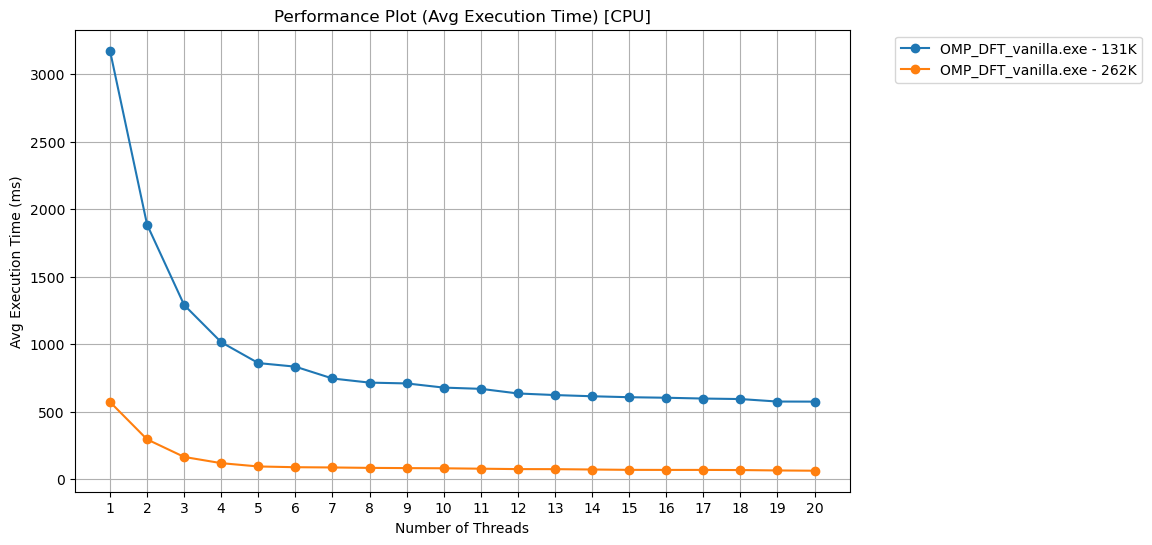

In [123]:
plot_scaling(
    "../tables/CPU_means.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['numbers_131072.txt', 'numbers_262144.txt'],
        'Executable': ['OMP_DFT_vanilla.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_DTF_vanilla_large.png"
)

Plot saved to ../tables\..\plots\speedup_DTF_vanilla.png


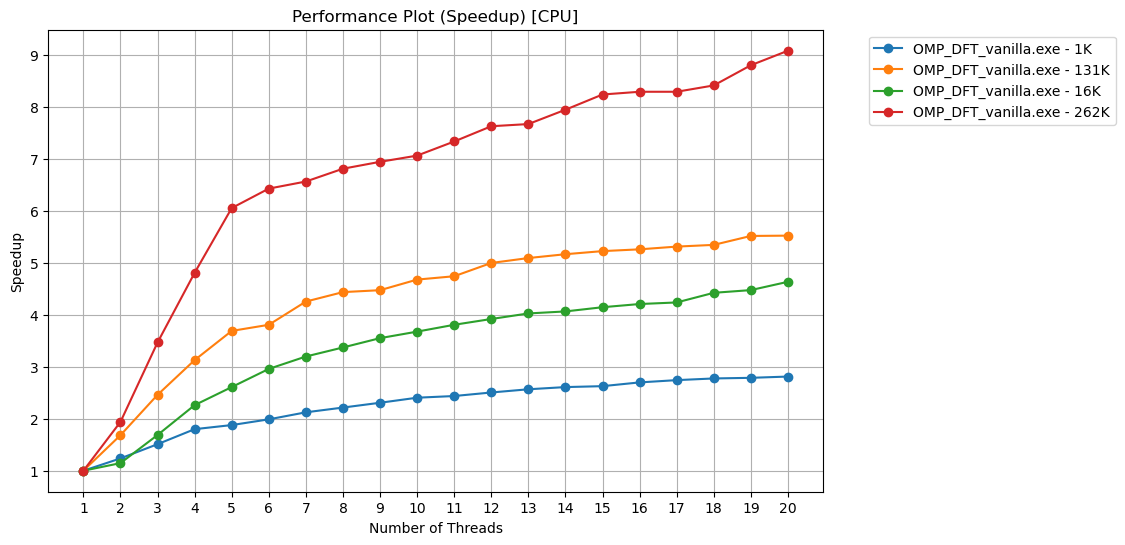

In [124]:
plot_scaling(
    "../tables/CPU_means.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['numbers_1024.txt','numbers_16384.txt', 'numbers_131072.txt', 'numbers_262144.txt'],
        'Executable': ['OMP_DFT_vanilla.exe']
    },
    show_speedup=True,
    save=True,
    filename="speedup_DTF_vanilla.png"
)

Plot saved to ../tables\..\plots\exec_time_DTF_optimized_small.png


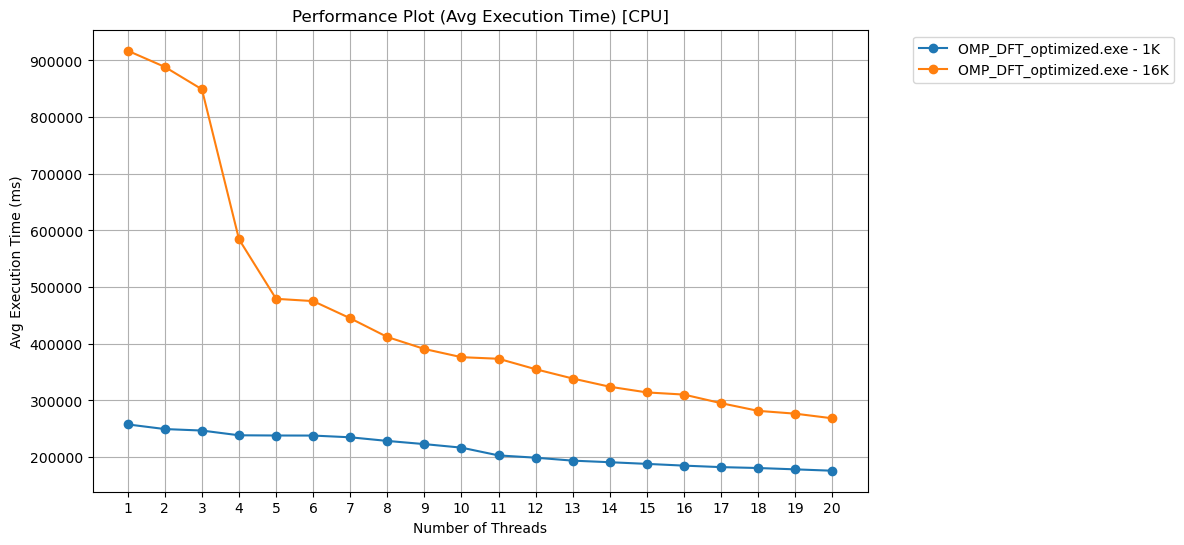

In [125]:
plot_scaling(
    "../tables/CPU_means.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['numbers_1024.txt','numbers_16384.txt'],
        'Executable': ['OMP_DFT_optimized.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_DTF_optimized_small.png"
)

Plot saved to ../tables\..\plots\exec_time_DTF_optimized_large.png


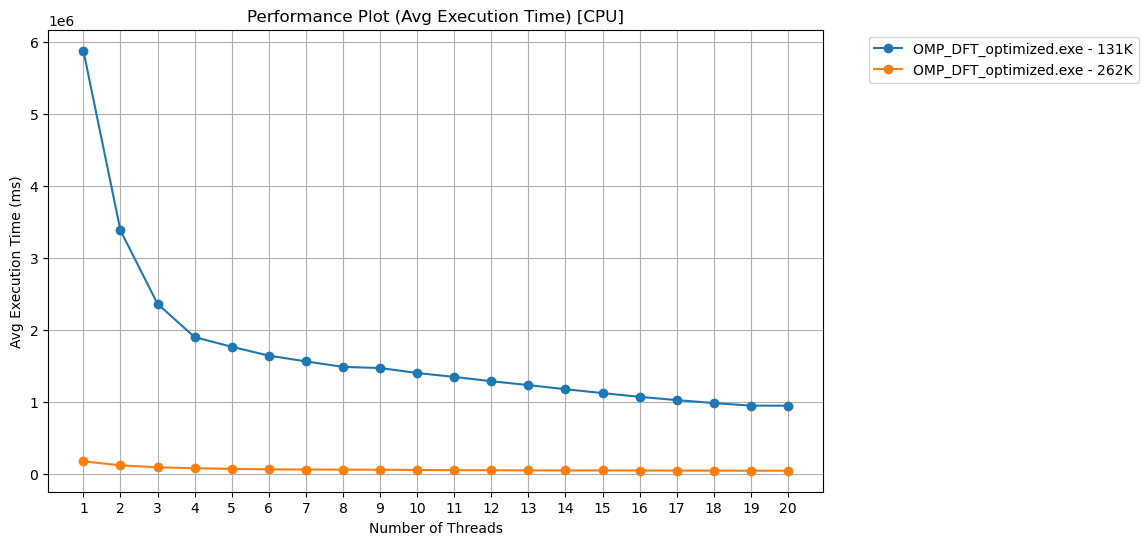

In [126]:
plot_scaling(
    "../tables/CPU_means.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['numbers_131072.txt', 'numbers_262144.txt'],
        'Executable': ['OMP_DFT_optimized.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_DTF_optimized_large.png"
)

Plot saved to ../tables\..\plots\speedup_DTF_optimized.png


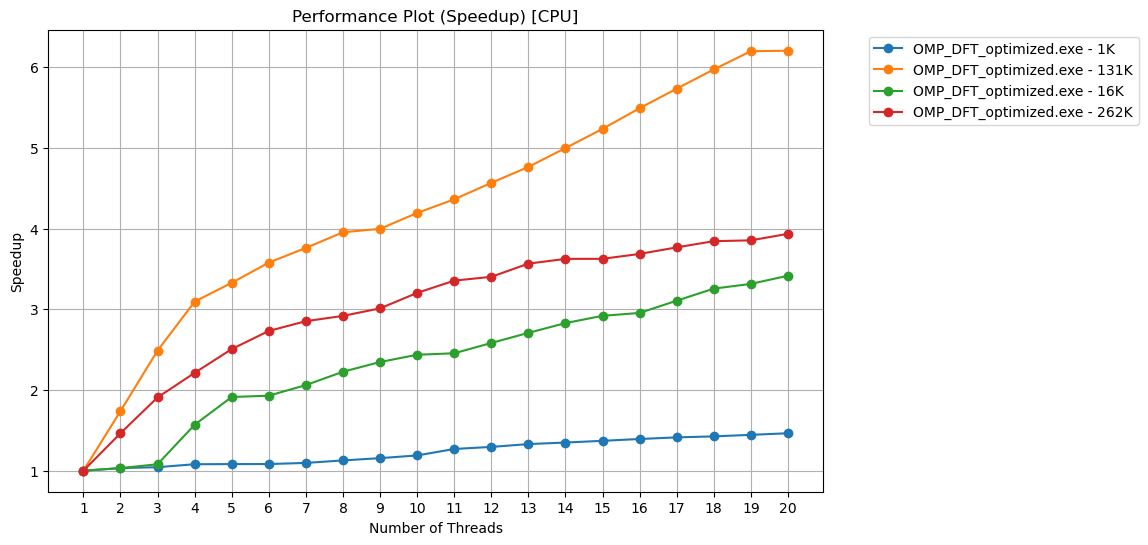

In [127]:
plot_scaling(
    "../tables/CPU_means.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['numbers_1024.txt','numbers_16384.txt', 'numbers_131072.txt', 'numbers_262144.txt'],
        'Executable': ['OMP_DFT_optimized.exe']
    },
    show_speedup=True,
    save=True,
    filename="speedup_DTF_optimized.png"
)

Plot saved to ../tables\..\plots\exec_time_FFT.png


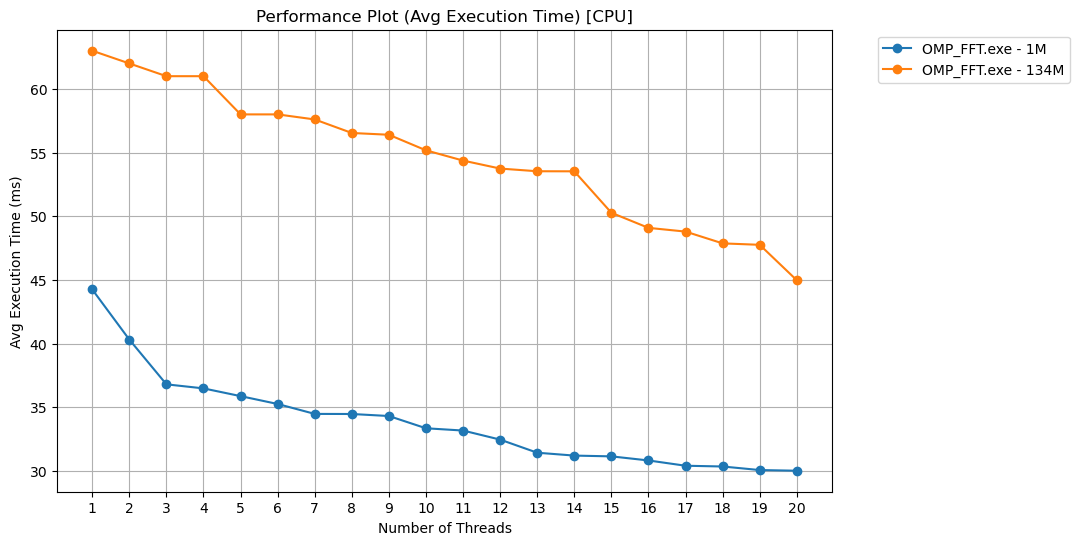

In [128]:
plot_scaling(
    "../tables/CPU_means.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['numbers_1048576.txt','numbers_134217728.txt'],
        'Executable': ['OMP_FFT.exe']
    },
    show_speedup=False,
    save=True,
    filename="exec_time_FFT.png"
)

Plot saved to ../tables\..\plots\speedup_FFT.png


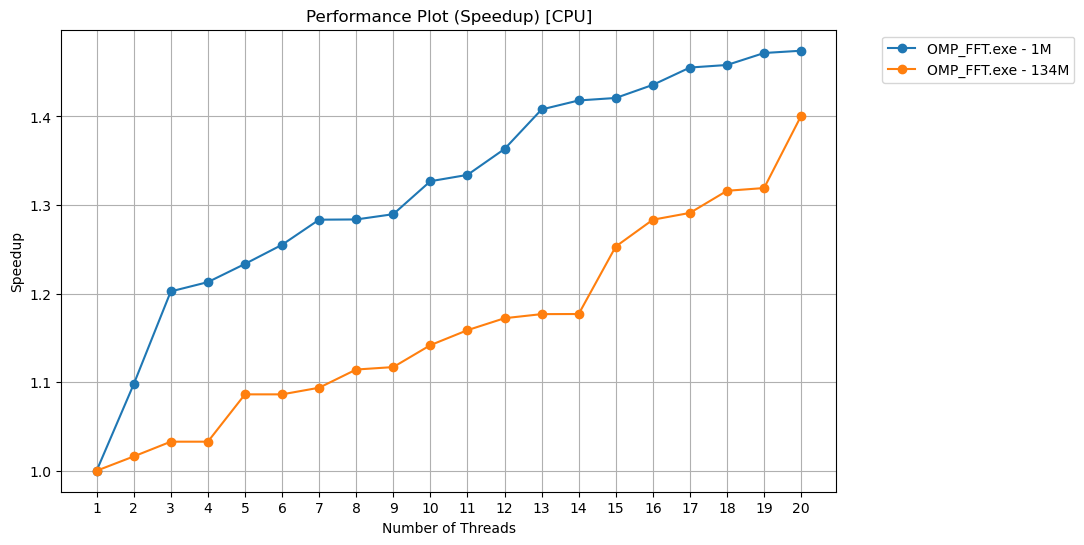

In [129]:
plot_scaling(
    "../tables/CPU_means.csv",
    filter_map={
        'Num Threads': [i for i in range(1, 21)],
        'Input File': ['numbers_1048576.txt','numbers_134217728.txt'],
        'Executable': ['OMP_FFT.exe']
    },
    show_speedup=True,
    save=True,
    filename="speedup_FFT.png"
)

In [130]:
list_files = [
    "numbers_2097152.txt",
    "numbers_4194304.txt",
    "numbers_8388608.txt",
    "numbers_16777216.txt",
    "numbers_33554432.txt",
    "numbers_67108864.txt",
    "numbers_134217728.txt"
]

executables = [
    "CUDA_fft_v01.exe",
    "CUDA_fft_v02.exe",
    "CUDA_fft_v03.exe"
]

Plot saved to ../tables\..\plots\exec_time_GPU_v01_2097152.png
Plot saved to ../tables\..\plots\exec_time_GPU_v01_4194304.png
Plot saved to ../tables\..\plots\exec_time_GPU_v01_8388608.png
Plot saved to ../tables\..\plots\exec_time_GPU_v01_16777216.png
Plot saved to ../tables\..\plots\exec_time_GPU_v01_33554432.png
Plot saved to ../tables\..\plots\exec_time_GPU_v01_67108864.png
Plot saved to ../tables\..\plots\exec_time_GPU_v01_134217728.png
Plot saved to ../tables\..\plots\exec_time_GPU_v02_2097152.png
Plot saved to ../tables\..\plots\exec_time_GPU_v02_4194304.png
Plot saved to ../tables\..\plots\exec_time_GPU_v02_8388608.png
Plot saved to ../tables\..\plots\exec_time_GPU_v02_16777216.png
Plot saved to ../tables\..\plots\exec_time_GPU_v02_33554432.png
Plot saved to ../tables\..\plots\exec_time_GPU_v02_67108864.png
Plot saved to ../tables\..\plots\exec_time_GPU_v02_134217728.png
Plot saved to ../tables\..\plots\exec_time_GPU_v03_2097152.png
Plot saved to ../tables\..\plots\exec_time_GP

C:\Users\polla\AppData\Local\Temp\ipykernel_17000\2875291425.py:74: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6))


Plot saved to ../tables\..\plots\exec_time_GPU_v03_134217728.png


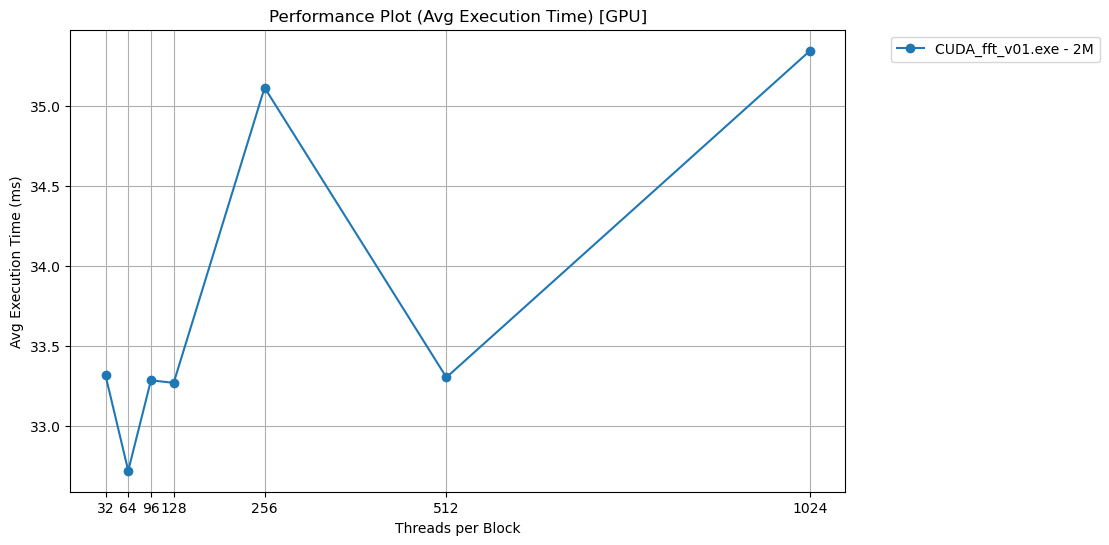

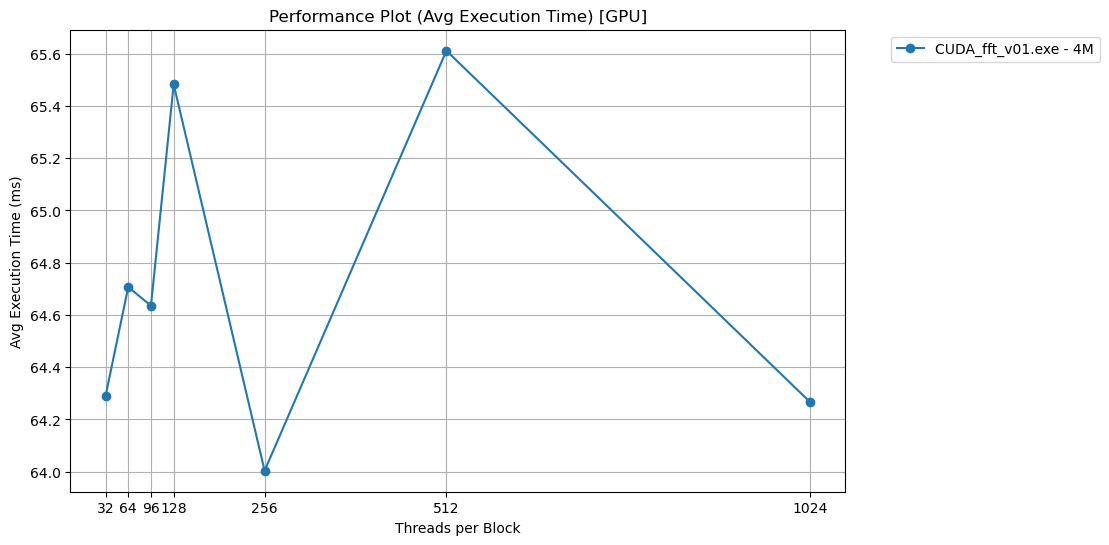

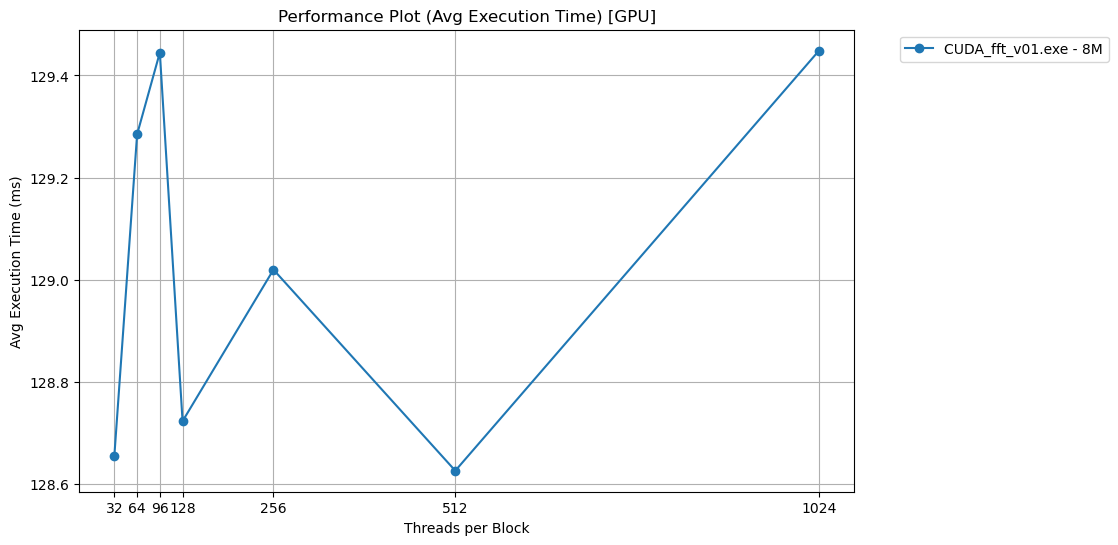

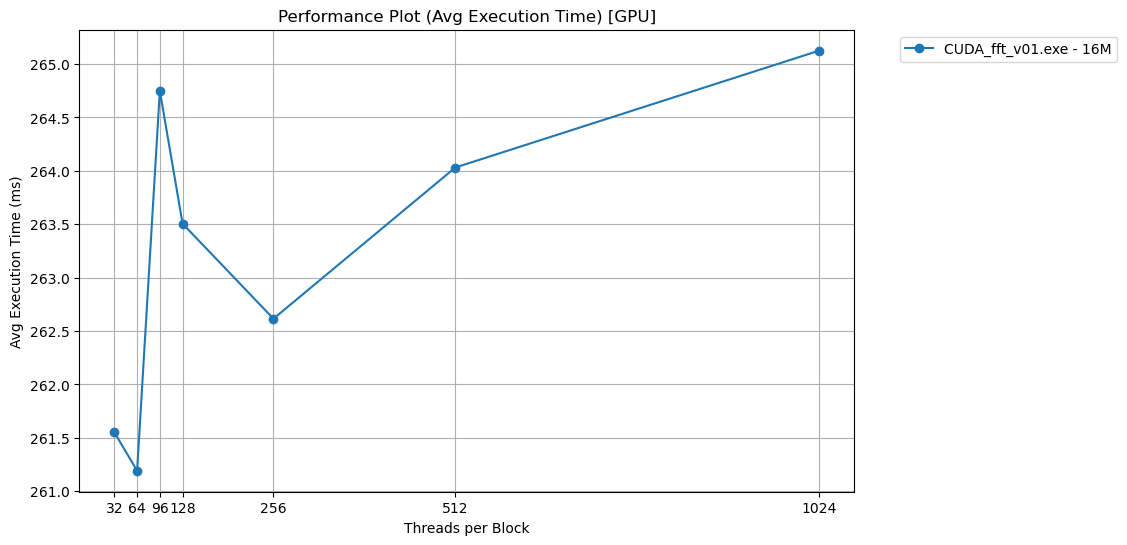

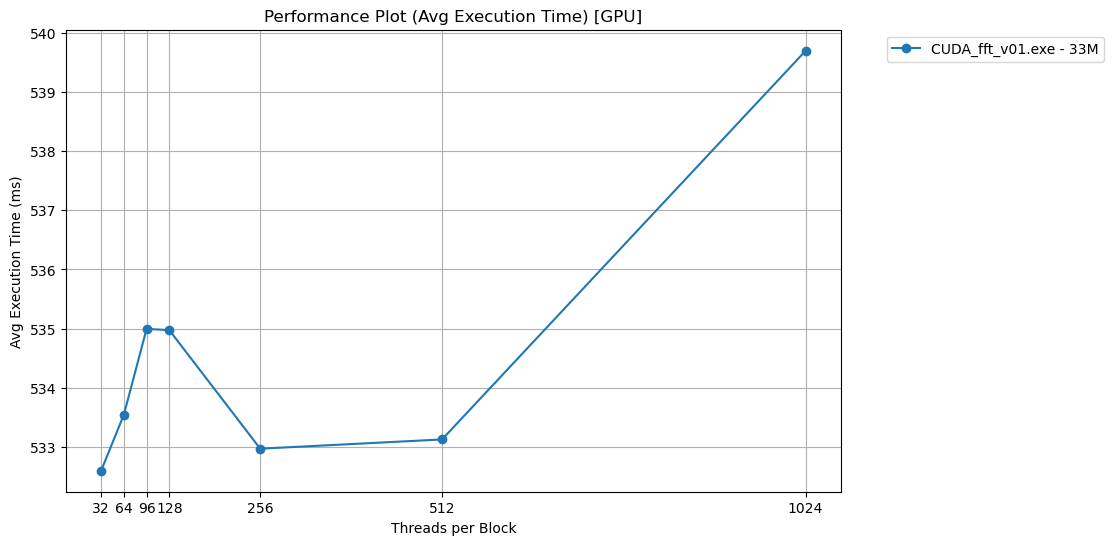

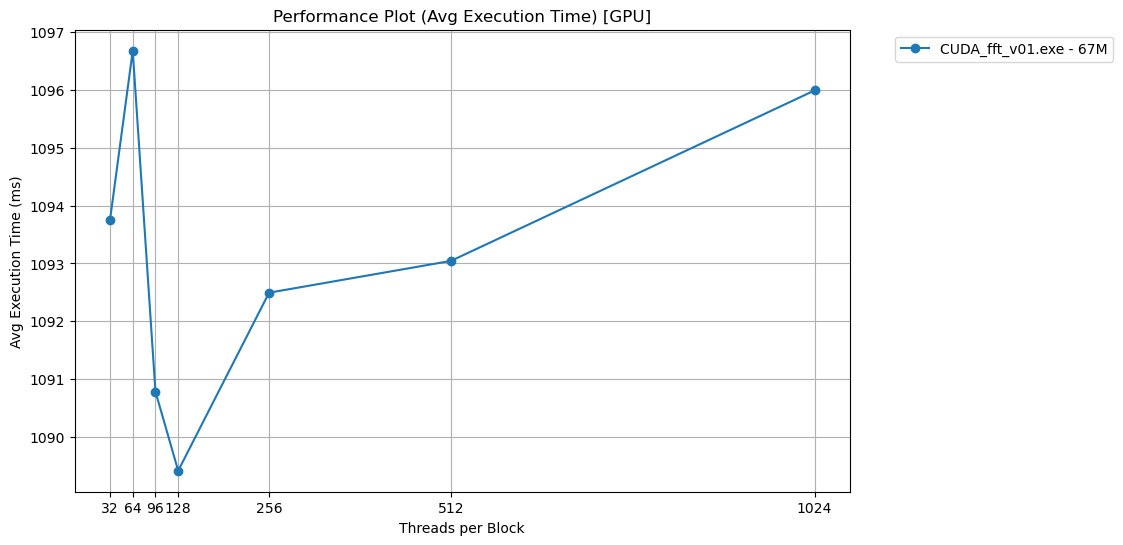

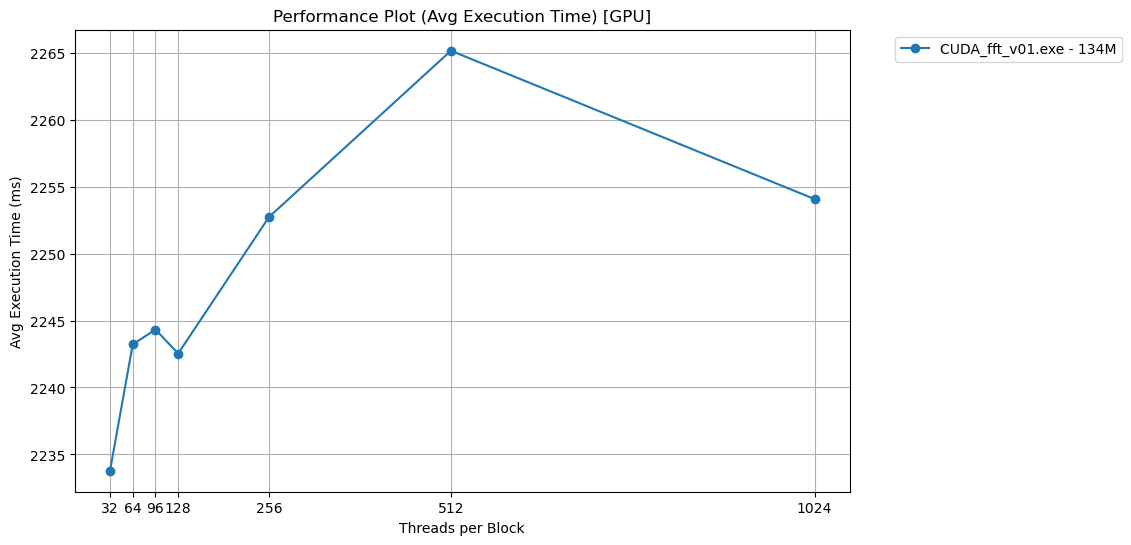

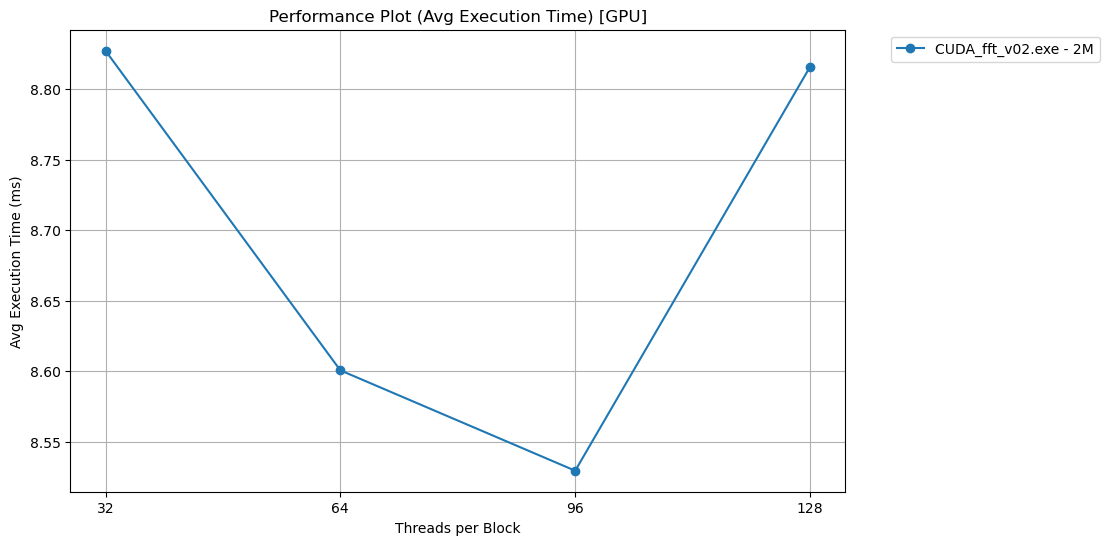

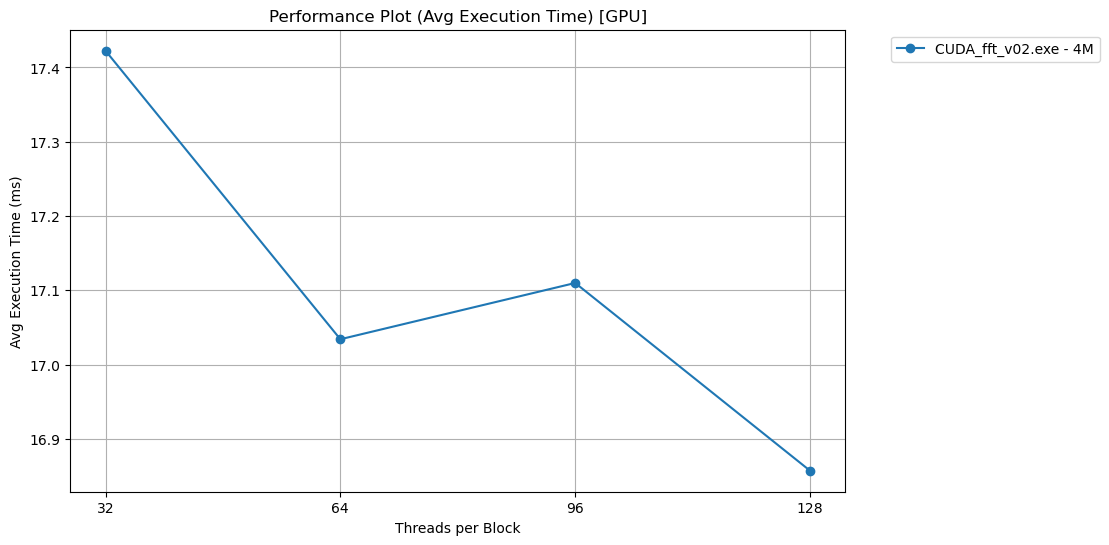

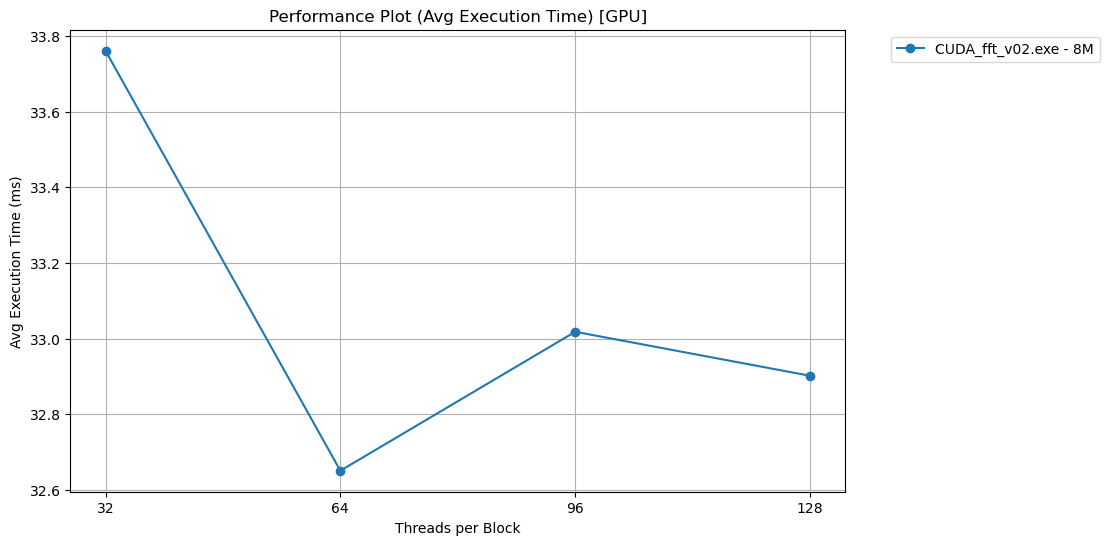

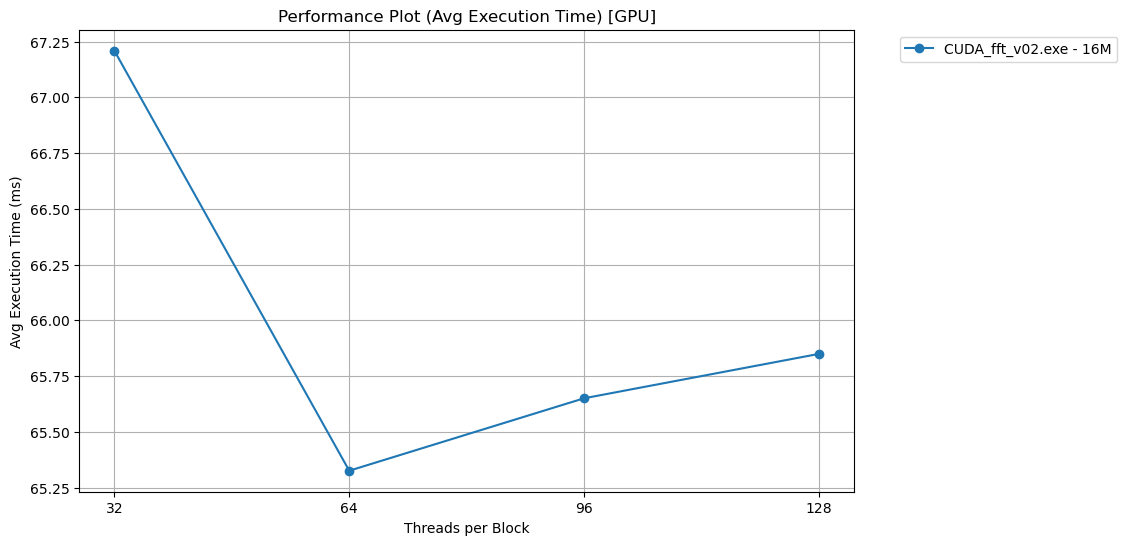

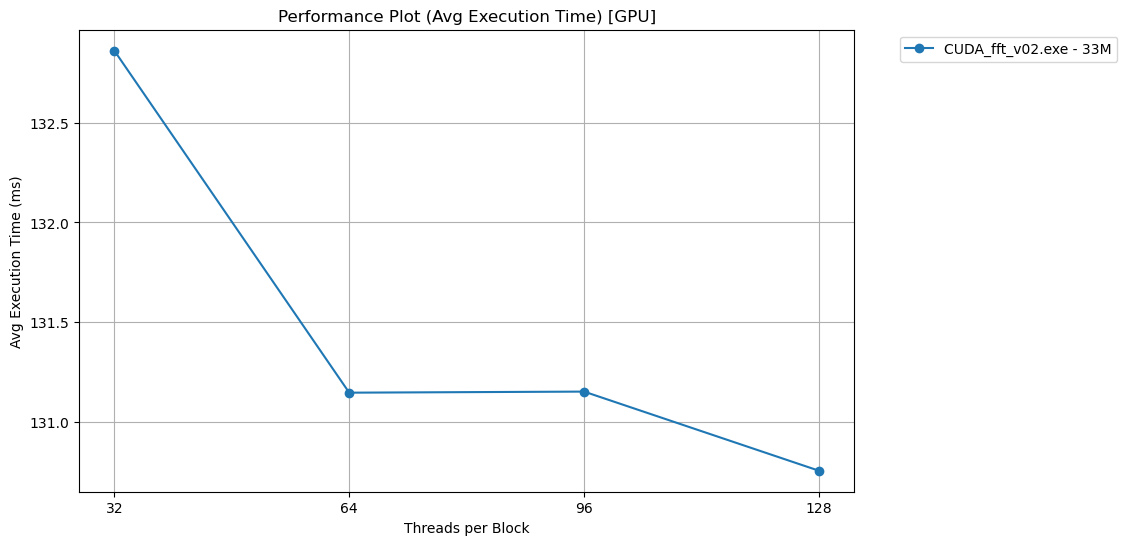

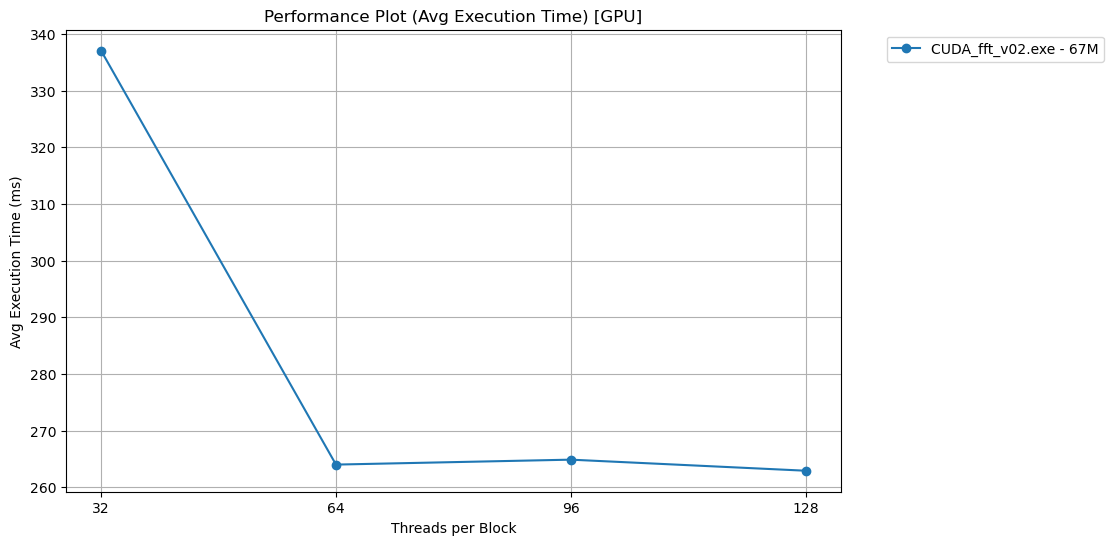

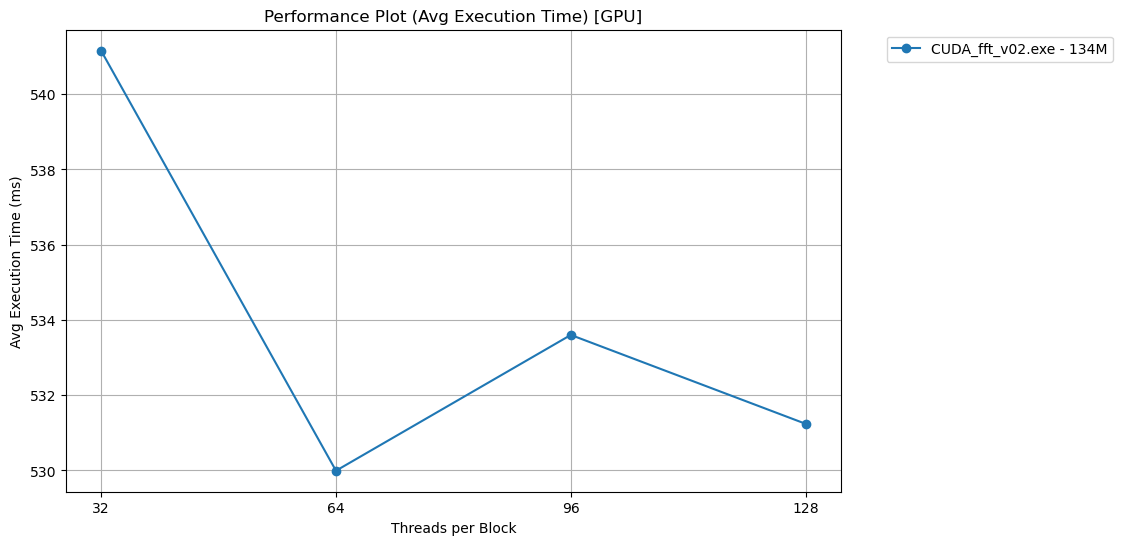

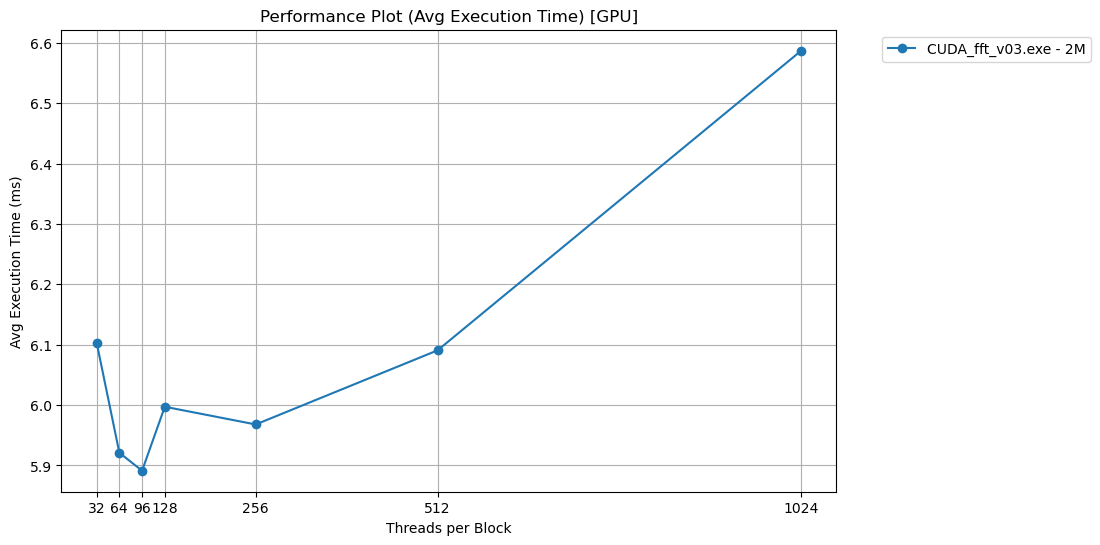

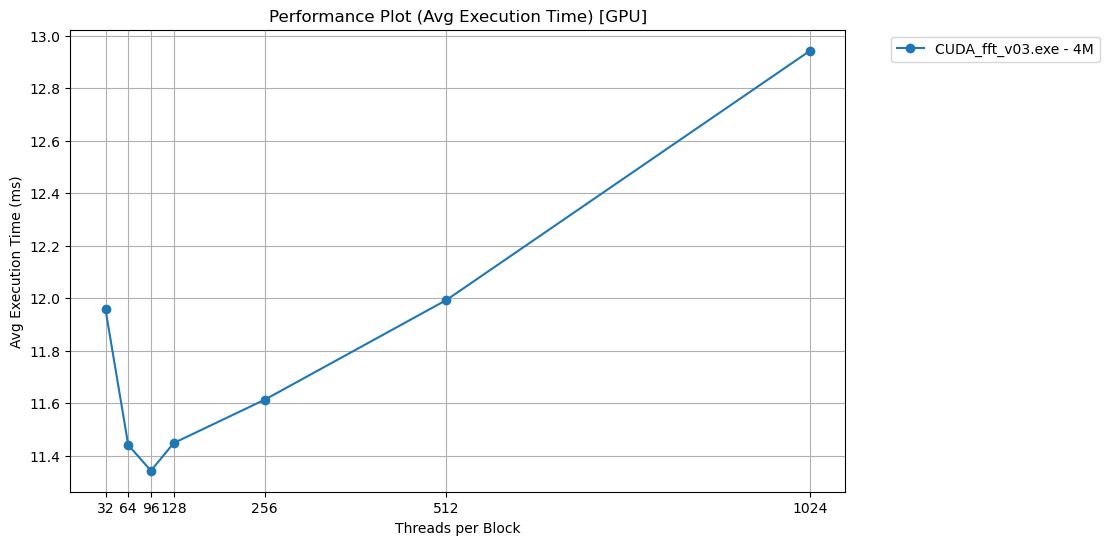

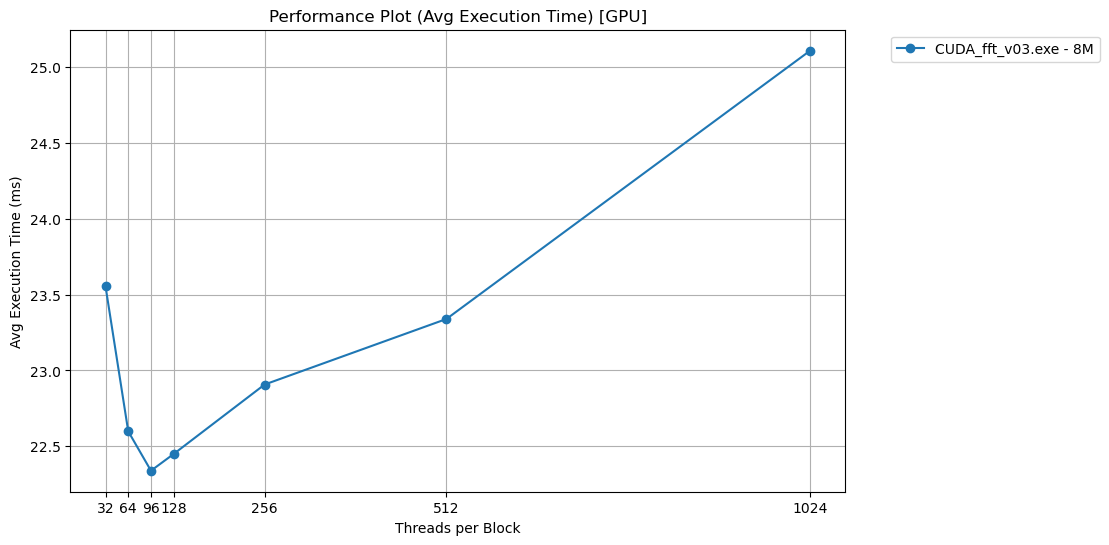

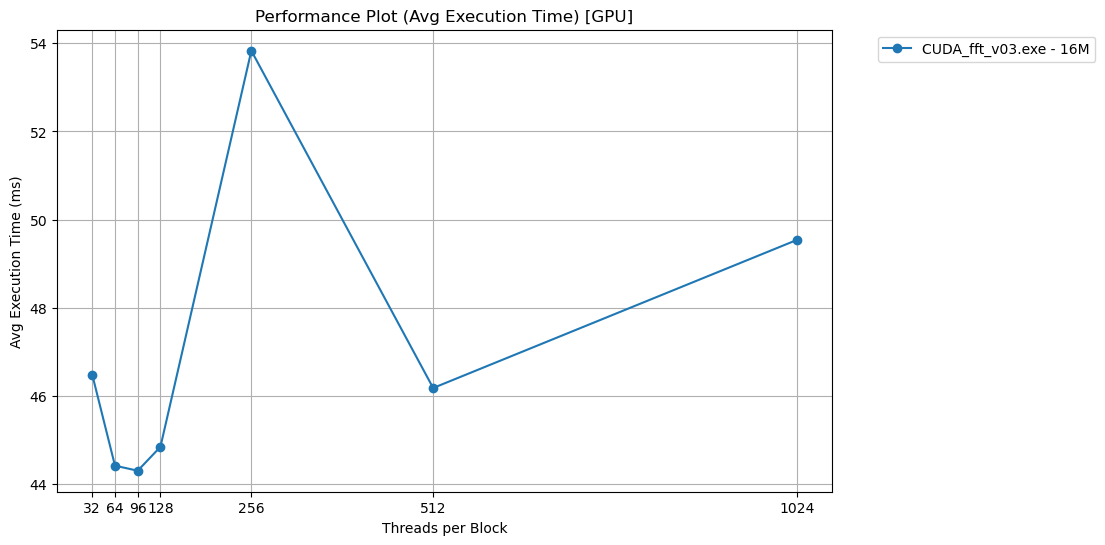

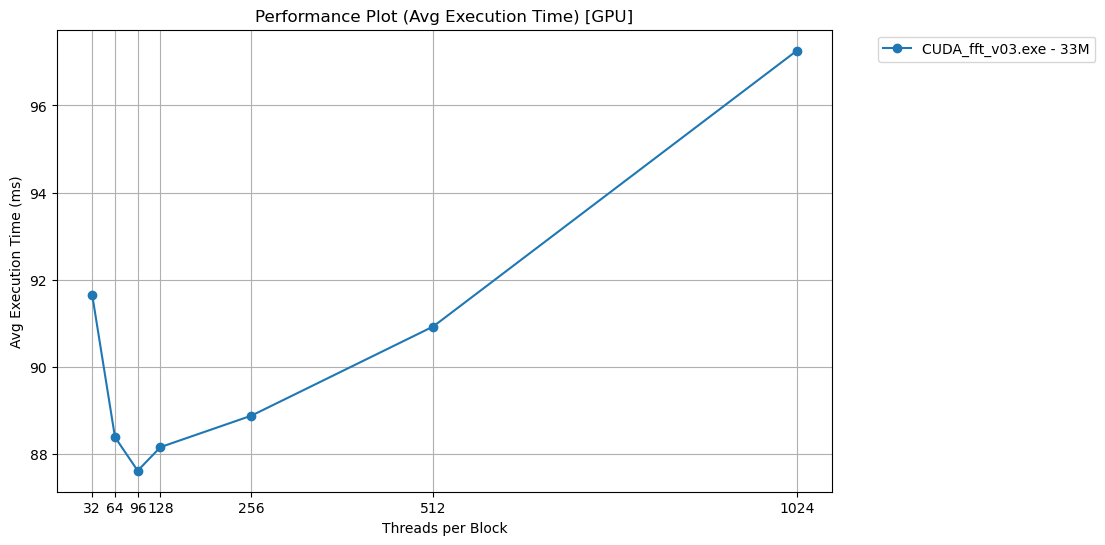

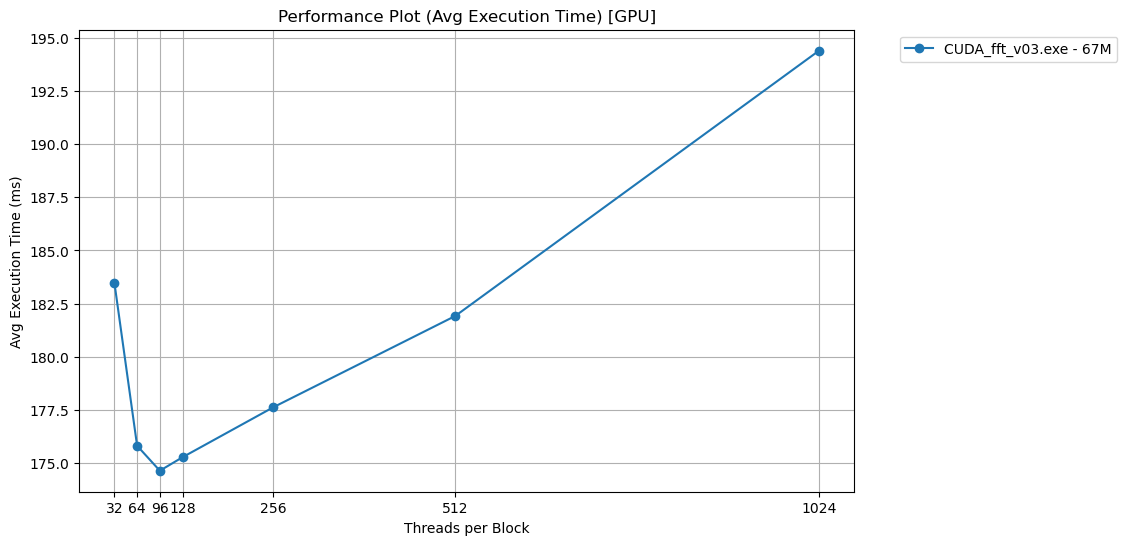

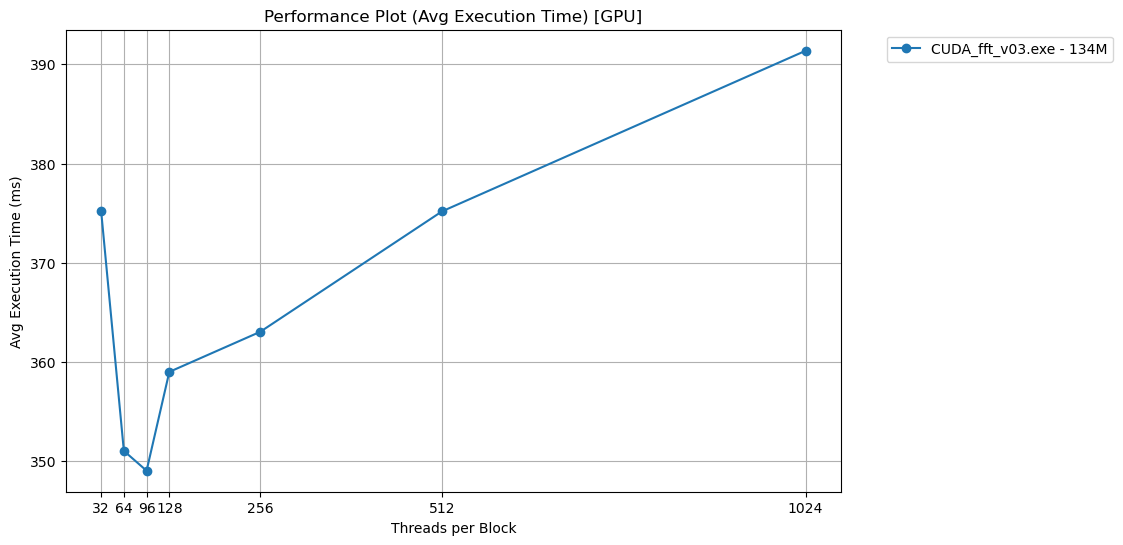

In [131]:
for executable in executables:
    for file in list_files:
        plot_scaling(
            "../tables/GPU_means.csv",
            filter_map={
                'Threads per Block': [32, 64, 96, 128, 256, 512, 1024],
                'Input File': [file],
                'Executable': [executable]
            },
            show_speedup=False,
            save=True,
            filename=f"exec_time_GPU_{executable.split('_')[2].split('.')[0]}_{file.split('_')[1].split('.')[0]}.png"
        )

Plot saved to ../tables\..\plots\exec_time_GPU_v01.png
Plot saved to ../tables\..\plots\exec_time_GPU_v02.png
Plot saved to ../tables\..\plots\exec_time_GPU_v03.png


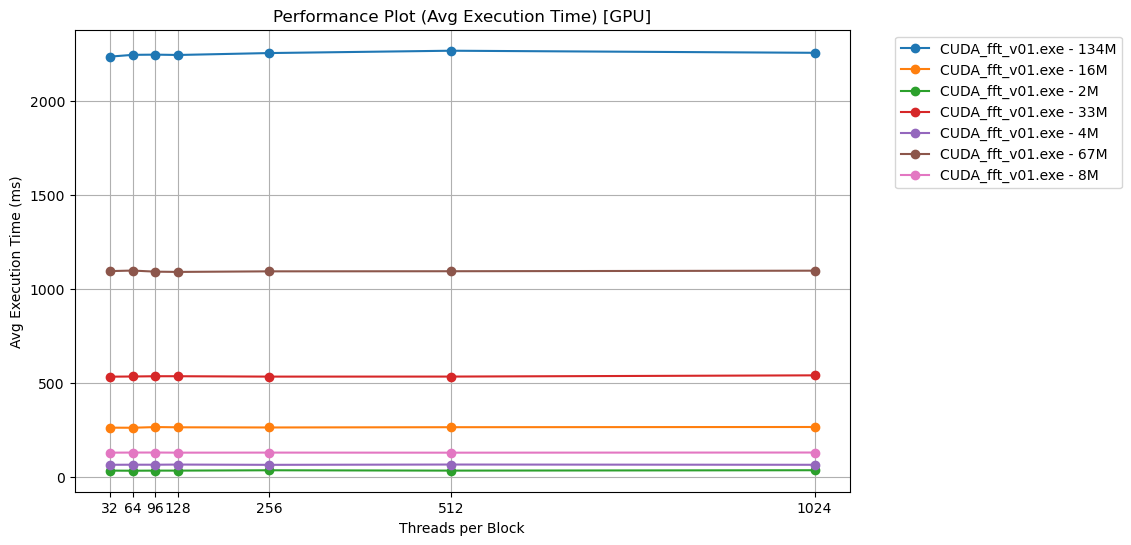

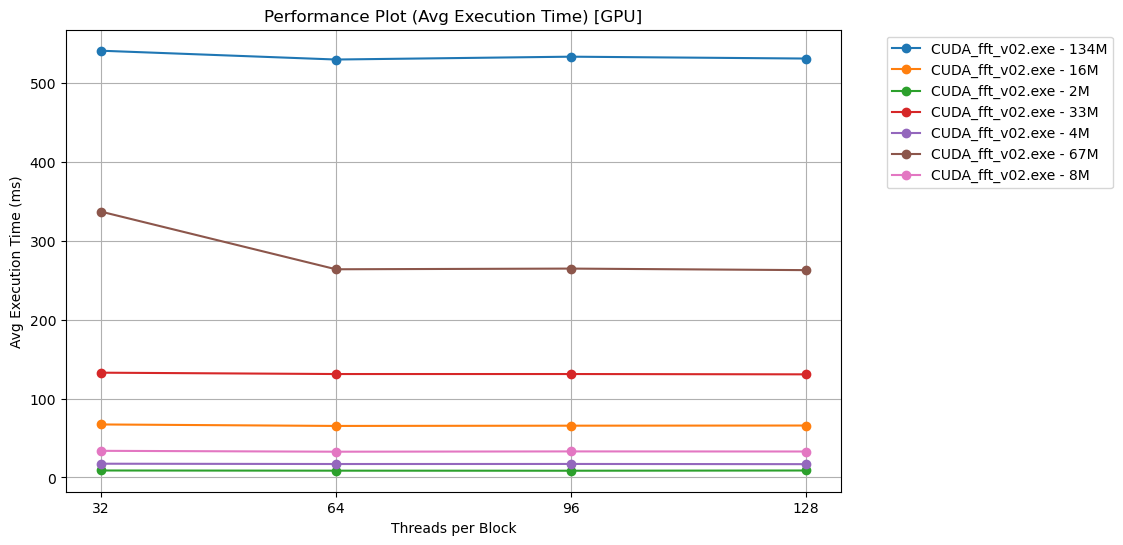

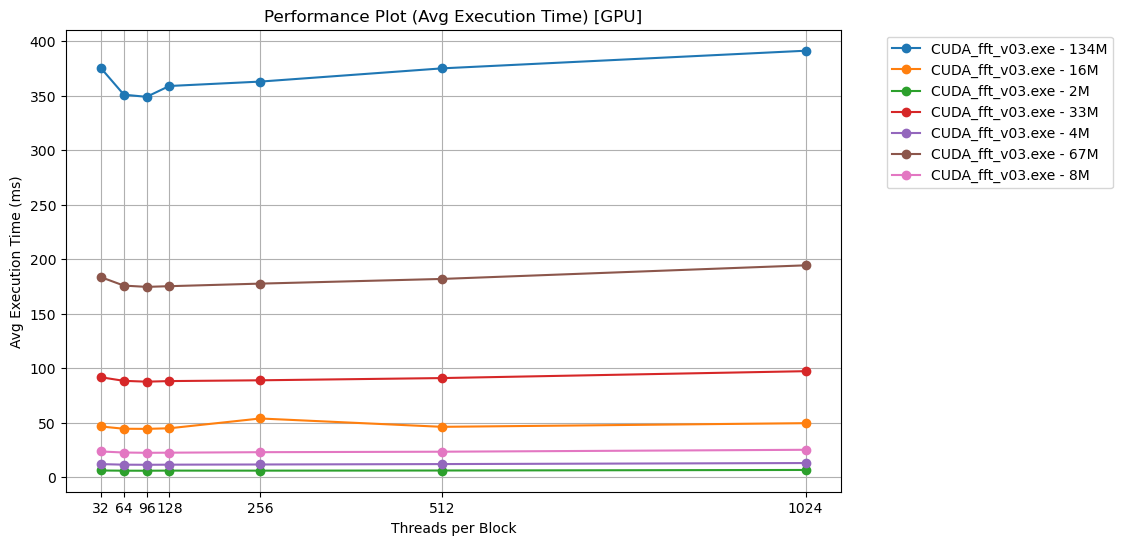

In [132]:
for executable in executables:
    plot_scaling(
        "../tables/GPU_means.csv",
        filter_map={
            'Threads per Block': [32, 64, 96, 128, 256, 512, 1024],
            'Input File': list_files,
            'Executable': [executable]
        },
        show_speedup=False,
        save=True,
        filename=f"exec_time_GPU_{executable.split('_')[2].split('.')[0]}.png"
    )

32 per fft1, 64 per fft5, 96 per fft7


In [133]:
def plot_GPU_overhead(csv_path, filter_map, save=False, filename=None):
    """
    Plot stacked execution times (Kernel + Transfer) vs input size,
    filtered by executable(s) and number of threads/threads per block.
    """
    # Load CSV
    df = pd.read_csv(csv_path)
    
    # Strip whitespace
    df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
    
    # Required columns
    required_cols = {"Executable", "Input File", "Avg Kernel Time (ms)", "Avg Transfer Time (ms)"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"CSV is missing required columns: {missing}")
        
    # Filter dataframe
    for col, values in filter_map.items():
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not in CSV")
        df = df[df[col].isin(values)]
    
    if df.empty:
        raise ValueError("No rows match the provided filters.")
    
    # Add numeric Input Size column for ordering
    df['Input Size'] = df['Input File'].str.extract(r'numbers_(\d+)\.txt').astype(int)
    
    plt.figure(figsize=(10,6))
    
    for exe in df['Executable'].unique():
        # Ordina per input size
        subset = df[df['Executable'] == exe].sort_values('Input Size')
        x_labels = [human_readable_size(v) for v in subset['Input Size']]
        kernel = subset['Avg Kernel Time (ms)'].values
        transfer = subset['Avg Transfer Time (ms)'].values

        # Indici equidistanti
        x = range(len(x_labels))

        # Grafico a barre stacked
        plt.bar(x, kernel, label='Kernel Time')
        plt.bar(x, transfer, bottom=kernel, label='Transfer Time')

        plt.xticks(x, x_labels, rotation=45)
        max_val = int(max(kernel + transfer)) + 200
        tick_size = 50 if max_val <= 1200 else 200 if max_val <= 5000 else 500
        plt.yticks(range(0, max_val, tick_size))


        plt.xlabel("Input Size")
        plt.ylabel("Time (ms)")
        plt.title(f"Execution Time Breakdown [{exe}]")
        plt.legend()
        
        # Griglia orizzontale
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout()
        
        if save:
            output_dir = os.path.join(os.path.dirname(csv_path), "..", "plots")
            os.makedirs(output_dir, exist_ok=True)
            if filename is None:
                filename = f"{exe}_execution_time.png"
            plt.savefig(os.path.join(output_dir, filename), bbox_inches='tight')
            print(f"Plot saved to {os.path.join(output_dir, filename)}")
        else:
            plt.show()

Plot saved to ../tables\..\plots\overhead_CUDA_fft_v01_32.png


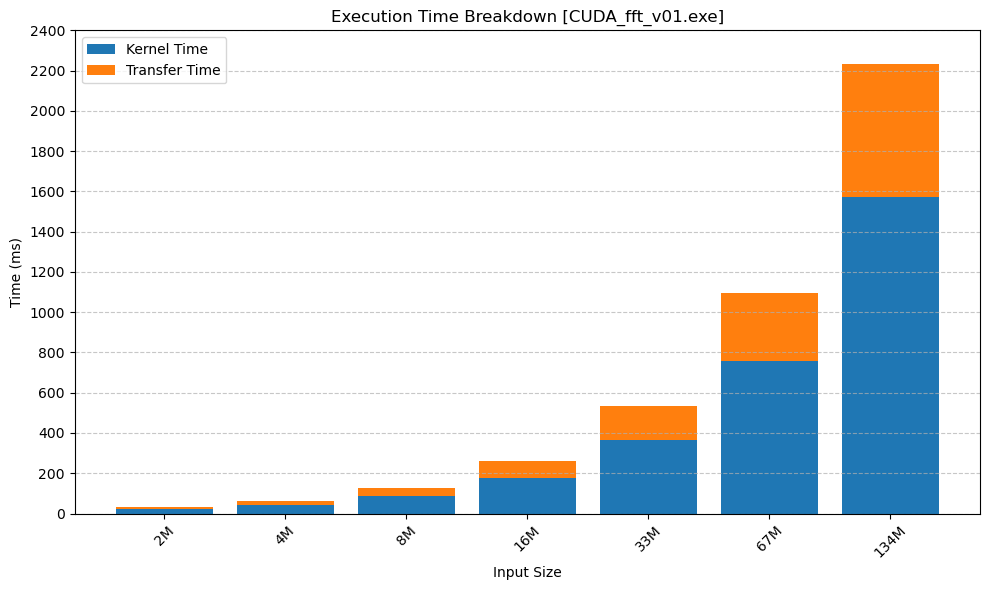

In [134]:
plot_GPU_overhead(
    "../tables/GPU_means.csv",
    filter_map={
        "Threads per Block": [32],
        "Executable": ["CUDA_fft_v01.exe"]
    },
    save=True,
    filename="overhead_CUDA_fft_v01_32.png"
)


Plot saved to ../tables\..\plots\overhead_CUDA_fft_v02_64.png


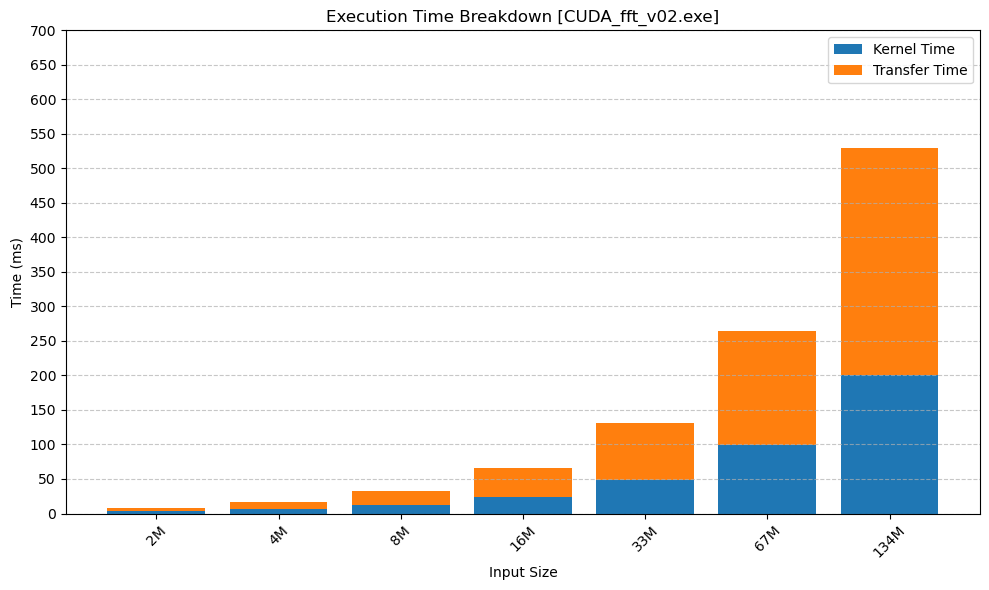

In [135]:
plot_GPU_overhead(
    "../tables/GPU_means.csv",
    filter_map={
        "Threads per Block": [64],
        "Executable": ["CUDA_fft_v02.exe"]
    },
    save=True,
    filename="overhead_CUDA_fft_v02_64.png"
)

Plot saved to ../tables\..\plots\overhead_CUDA_fft_v03_96.png


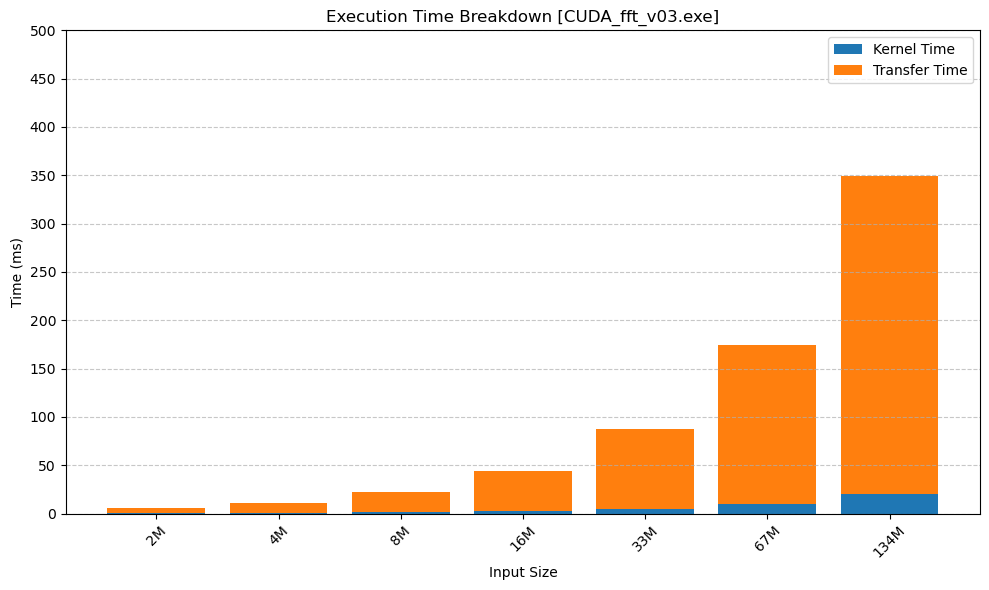

In [136]:
plot_GPU_overhead(
    "../tables/GPU_means.csv",
    filter_map={
        "Threads per Block": [96],
        "Executable": ["CUDA_fft_v03.exe"]
    },
    save=True,
    filename="overhead_CUDA_fft_v03_96.png"
)